In [35]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

In [28]:
data = pd.read_csv(r'playground-series-s3e19/train.csv')

## EDA

In [29]:
data.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [30]:
data.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


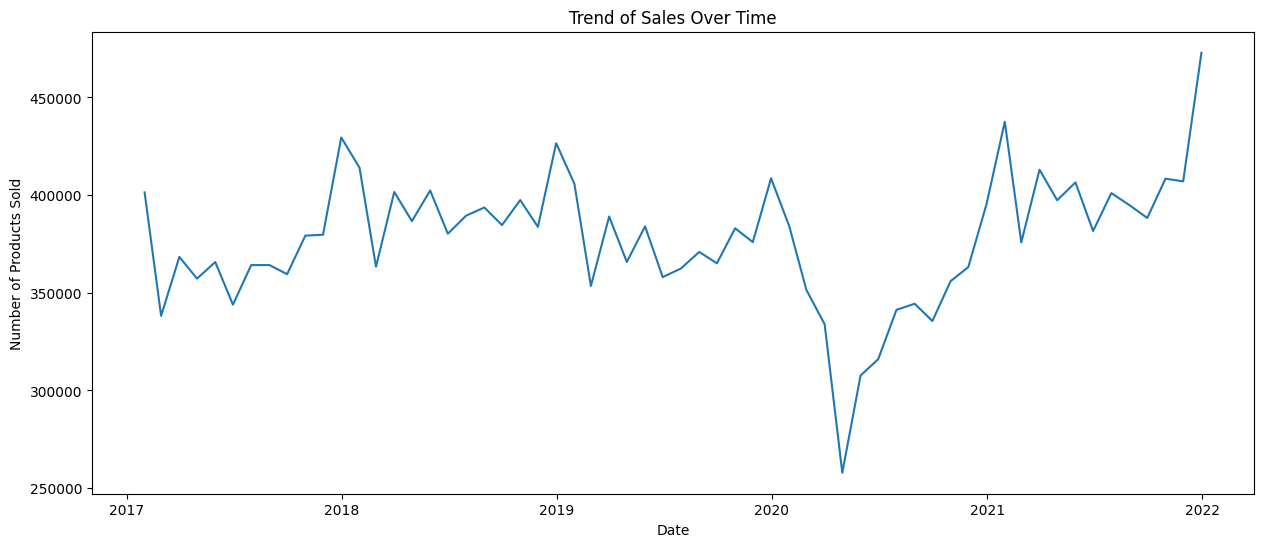

In [31]:
# Convert `date` to datetime format
data['date'] = pd.to_datetime(data['date'])

# Aggregate sales on a monthly basis
monthly_sales = data.resample('M', on='date').sum()['num_sold']

# Plot the trend of sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

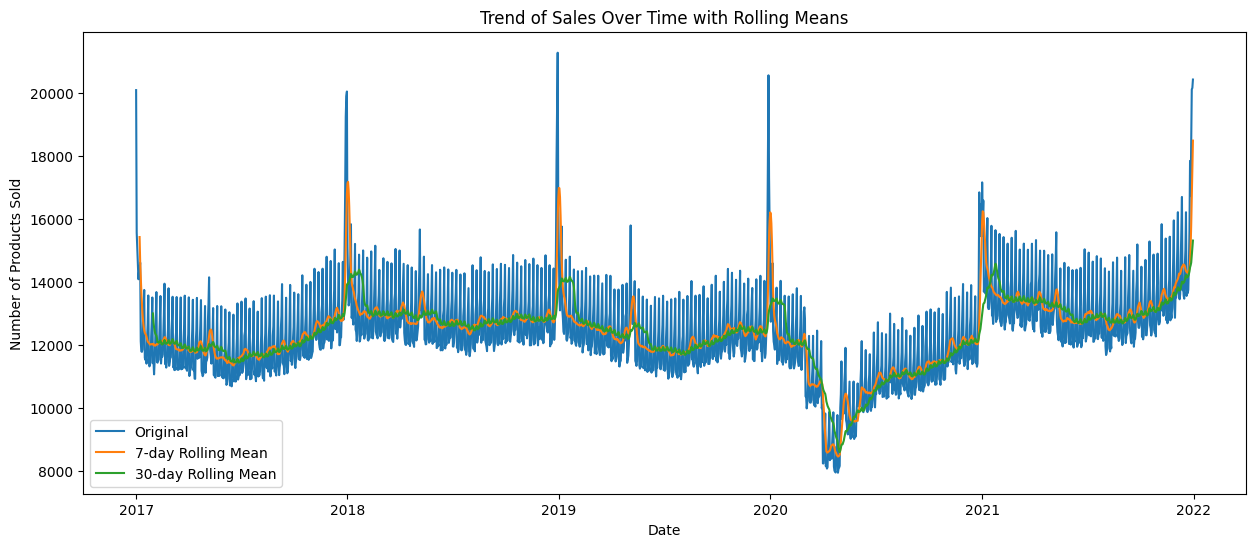

In [32]:
# Aggregate sales on a daily basis
daily_sales = data.resample('D', on='date').sum()['num_sold']

# Calculate 7-day and 30-day rolling means
daily_sales_rolling_7d = daily_sales.rolling(window=7).mean()
daily_sales_rolling_30d = daily_sales.rolling(window=30).mean()

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_sales.index, y=daily_sales.values, label='Original')
sns.lineplot(x=daily_sales_rolling_7d.index, y=daily_sales_rolling_7d.values, label='7-day Rolling Mean')
sns.lineplot(x=daily_sales_rolling_30d.index, y=daily_sales_rolling_30d.values, label='30-day Rolling Mean')
plt.title('Trend of Sales Over Time with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()

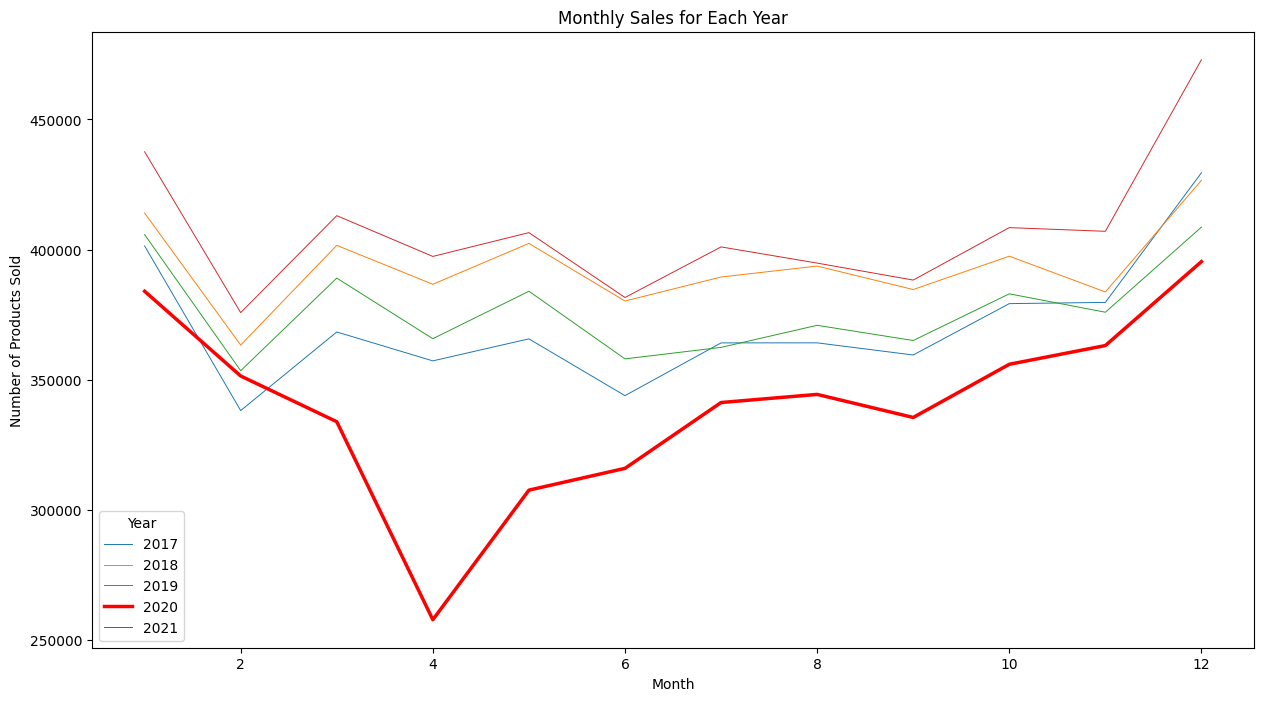

In [33]:
# Aggregate sales on a monthly basis for each year
monthly_sales_year = data.resample('M', on='date').sum()['num_sold'].reset_index()

# Create a column for the year
monthly_sales_year['year'] = monthly_sales_year['date'].dt.year

# Create a line plot for each year
plt.figure(figsize=(15, 8))
for year in sorted(monthly_sales_year['year'].unique()):
    year_data = monthly_sales_year[monthly_sales_year['year'] == year]
    if year == 2020:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=2.5, color='red')
    else:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=0.7)
plt.title('Monthly Sales for Each Year')
plt.xlabel('Month')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.show()

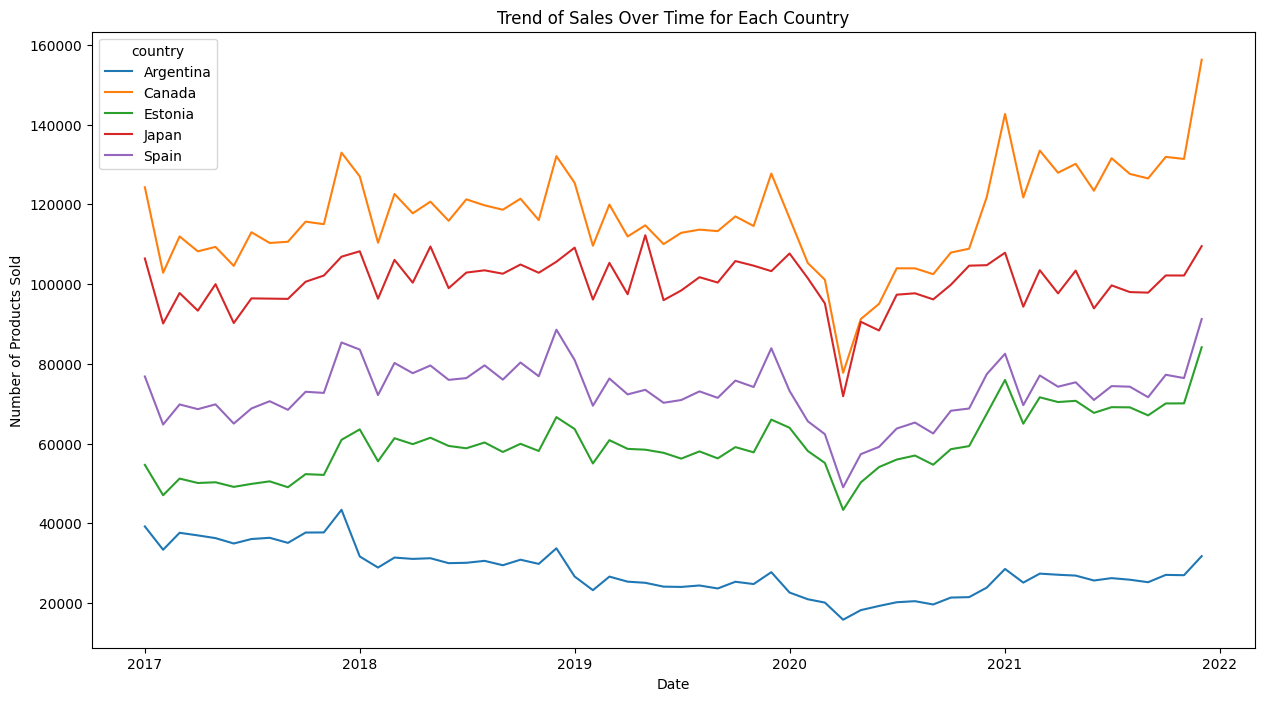

In [27]:

monthly_sales_country = data.groupby([data['date'].dt.to_period('M'), 'country'])['num_sold'].sum().reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()

# Create a line plot for each country
plt.figure(figsize=(15, 8))
sns.lineplot(data=monthly_sales_country, x='date', y='num_sold', hue='country')
plt.title('Trend of Sales Over Time for Each Country')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

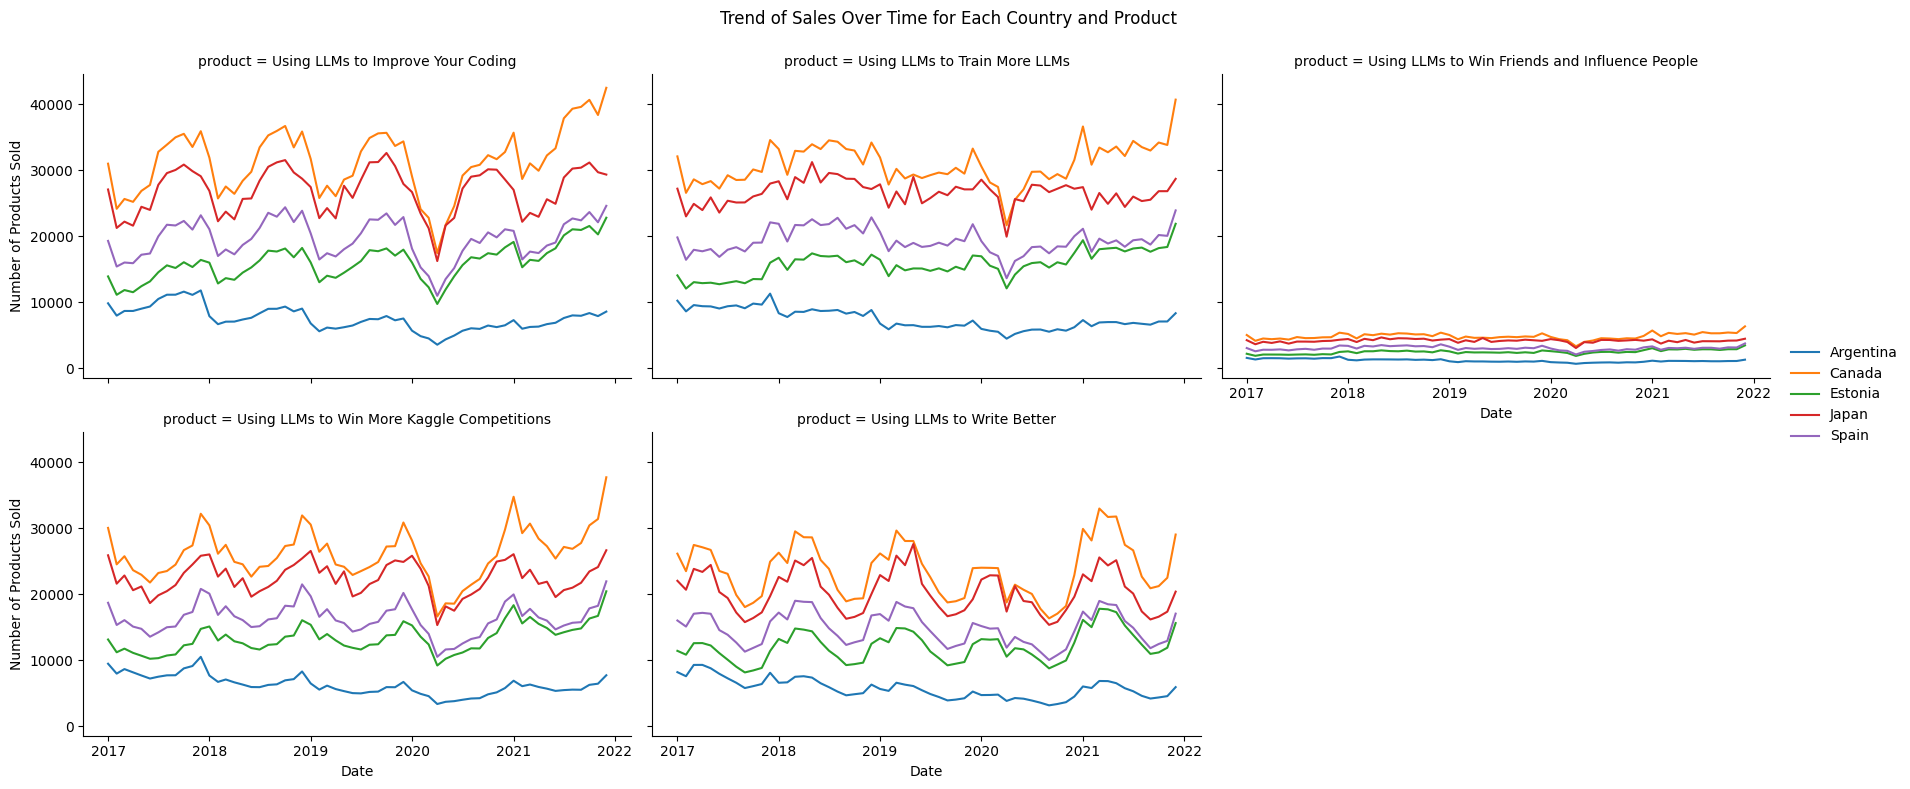

In [34]:
monthly_sales_country_product = data.groupby([data['date'].dt.to_period('M'), 'country', 'product'])['num_sold'].sum().reset_index()
monthly_sales_country_product['date'] = monthly_sales_country_product['date'].dt.to_timestamp()

# Create a FacetGrid to make a separate line plot for each product
g = sns.FacetGrid(monthly_sales_country_product, col='product', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='date', y='num_sold', hue='country')
g.set_axis_labels('Date', 'Number of Products Sold')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend of Sales Over Time for Each Country and Product')
plt.show()

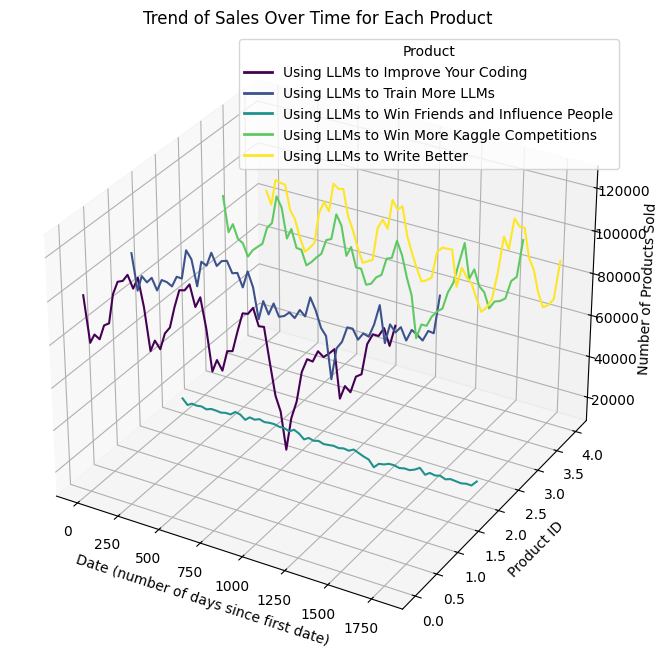

In [36]:
monthly_sales_product = data.groupby([data['date'].dt.to_period('M'), 'product'])['num_sold'].sum().reset_index()
monthly_sales_product['date'] = monthly_sales_product['date'].dt.to_timestamp()

# Assign each product a unique numeric ID
product_ids = {product: i for i, product in enumerate(monthly_sales_product['product'].unique())}
monthly_sales_product['product_id'] = monthly_sales_product['product'].map(product_ids)

# Convert 'date' to a numeric form (number of days since the first date)
monthly_sales_product['date_num'] = (monthly_sales_product['date'] - monthly_sales_product['date'].min()).dt.days

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the different products
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_sales_product['product'].unique())))


# Plot a line for each product
for i, product in enumerate(monthly_sales_product['product'].unique()):
    product_data = monthly_sales_product[monthly_sales_product['product'] == product]
    ax.plot(product_data['date_num'], product_data['product_id'], product_data['num_sold'], color=colors[i])

# Set the labels and title
ax.set_xlabel('Date (number of days since first date)')
ax.set_ylabel('Product ID')
ax.set_zlabel('Number of Products Sold')
ax.set_title('Trend of Sales Over Time for Each Product')

# Create a legend for the product IDs
ax.legend([plt.Line2D([0], [0], color=color, lw=2) for color in colors],
          product_ids.keys(),
          title='Product',
          loc='upper right')

plt.show()

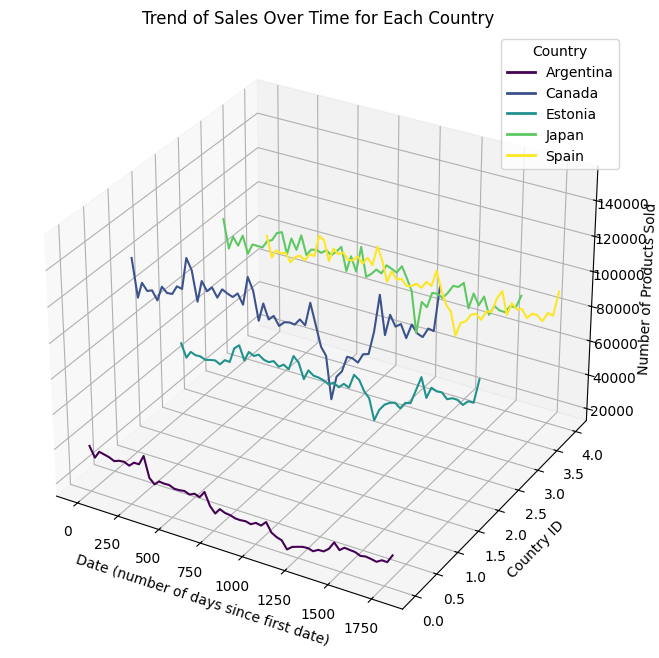

In [37]:
# Assign each country a unique numeric ID
country_ids = {country: i for i, country in enumerate(data['country'].unique())}
data['country_id'] = data['country'].map(country_ids)


# Aggregate sales on a monthly basis for each country
monthly_sales_country = data.groupby([data['date'].dt.to_period('M'), 'country'])['num_sold'].sum().reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()
monthly_sales_country['country_id'] = monthly_sales_country['country'].map(country_ids)

# Convert 'date' to a numeric form (number of days since the first date)
monthly_sales_country['date_num'] = (monthly_sales_country['date'] - monthly_sales_country['date'].min()).dt.days

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a line for each country
for i, country in enumerate(monthly_sales_country['country'].unique()):
    country_data = monthly_sales_country[monthly_sales_country['country'] == country]
    ax.plot(country_data['date_num'], country_data['country_id'], country_data['num_sold'], color=colors[i])

# Set the labels and title
ax.set_xlabel('Date (number of days since first date)')
ax.set_ylabel('Country ID')
ax.set_zlabel('Number of Products Sold')
ax.set_title('Trend of Sales Over Time for Each Country')

# Create a legend for the country IDs
ax.legend([plt.Line2D([0], [0], color=color, lw=2) for color in colors],
          country_ids.keys(),
          title='Country',
          loc='upper right')

plt.show()

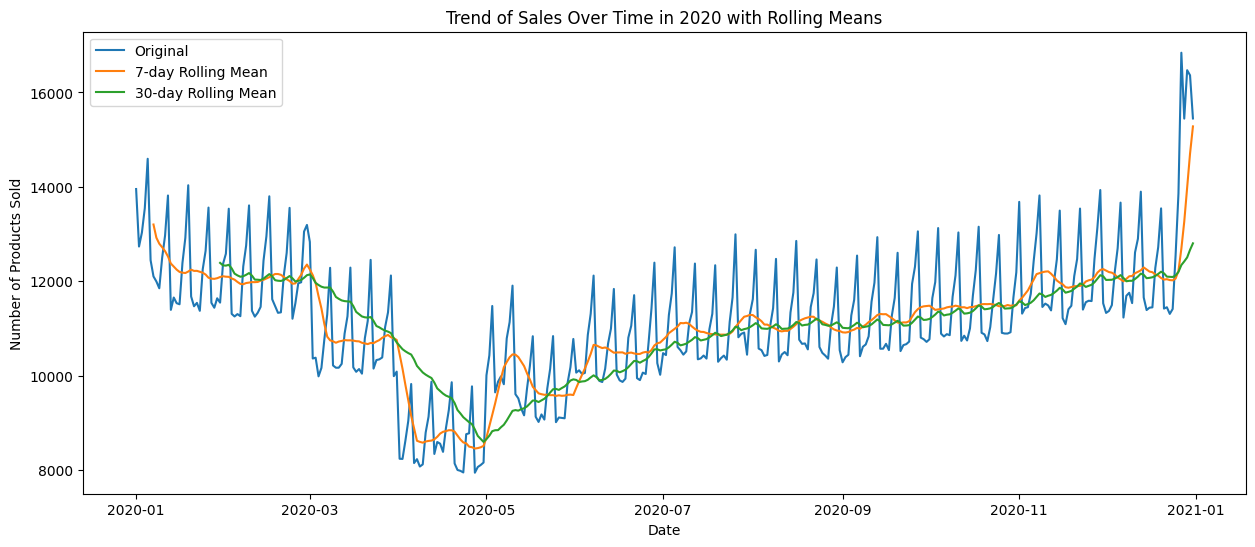

In [38]:
data_2020 = data[(data['date'].dt.year == 2020)]

# Aggregate sales on a daily basis
daily_sales_2020 = data_2020.resample('D', on='date').sum()['num_sold']

# Calculate 7-day and 30-day rolling means
daily_sales_2020_rolling_7d = daily_sales_2020.rolling(window=7).mean()
daily_sales_2020_rolling_30d = daily_sales_2020.rolling(window=30).mean()

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_sales_2020.index, y=daily_sales_2020.values, label='Original')
sns.lineplot(x=daily_sales_2020_rolling_7d.index, y=daily_sales_2020_rolling_7d.values, label='7-day Rolling Mean')
sns.lineplot(x=daily_sales_2020_rolling_30d.index, y=daily_sales_2020_rolling_30d.values, label='30-day Rolling Mean')
plt.title('Trend of Sales Over Time in 2020 with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()

## Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor


import holidays
import dateutil.easter as easter

ModuleNotFoundError: No module named 'lightgbm'